In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import string

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('whitegrid')

In [2]:
data1 = pd.read_json('D:\Sarcasm_Headlines_Dataset.json', lines=True)
data2 = pd.read_json('D:\Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = pd.concat([data1, data2], ignore_index=True)
df.head(10)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


Text(0.5, 1.0, 'Countplot of headlines')

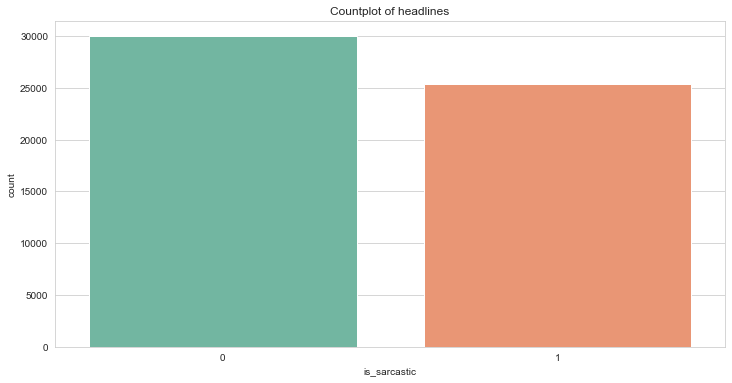

In [3]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [4]:
# Add new column 'headline_len': Text length of headline 
df['headline_len'] = df['headline'].map(len)

In [5]:
# Define function which takes full article link and extract string with website name
def extract_website(link):
  return link.split('//')[1].split('.com')[0].replace('www.', "")

In [6]:
# Apply extract_website func to df article_link and create new column with website name
df['website'] = df['article_link'].apply((lambda x: extract_website(x)))

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'huffingtonpost'),
  Text(1, 0, 'local.theonion'),
  Text(2, 0, 'politics.theonion'),
  Text(3, 0, 'entertainment.theonion'),
  Text(4, 0, 'theonion'),
  Text(5, 0, 'sports.theonion'),
  Text(6, 0, 'ogn.theonion')])

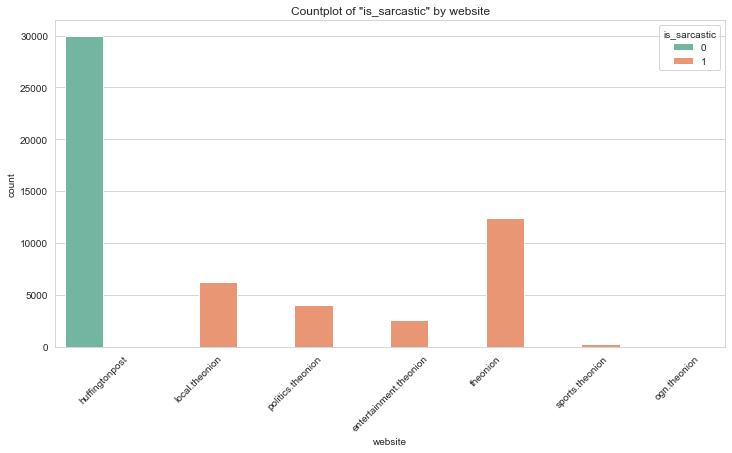

In [7]:
# Check number of headlines by is_sarcastic for every website
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'website', hue='is_sarcastic', palette="Set2").set_title('Countplot of "is_sarcastic" by website')
plt.xticks(rotation=45)

In [8]:
# Sort dataframe by headline length. Check the longest headline.
df.sort_values(by='headline_len', ascending=False).head(4)

,article_link,headline,is_sarcastic,headline_len,website
34011,https://www.theonion.com/hot-wheels-ranked-num...,hot wheels ranked number one toy for rolling d...,1,926,theonion
28855,https://www.theonion.com/maya-angelou-poet-aut...,"maya angelou, poet, author, civil rights activ...",1,254,theonion
19868,https://www.theonion.com/maya-angelou-poet-aut...,"maya angelou, poet, author, civil rights activ...",1,254,theonion
43297,https://entertainment.theonion.com/12-years-a-...,"'12 years a slave,' 'captain phillips,' 'ameri...",1,238,entertainment.theonion


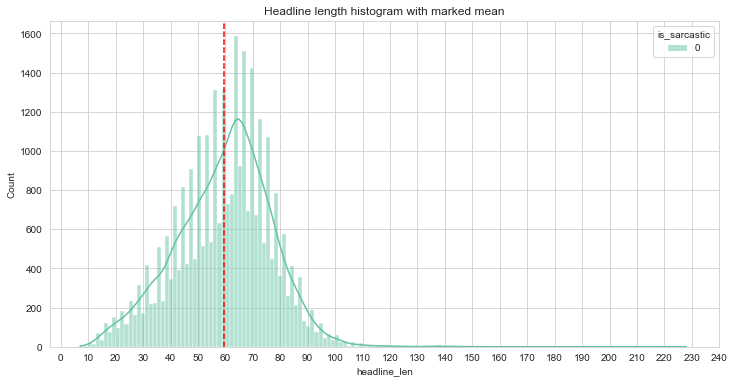

In [9]:
# Histogram of headline length for not "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 0
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

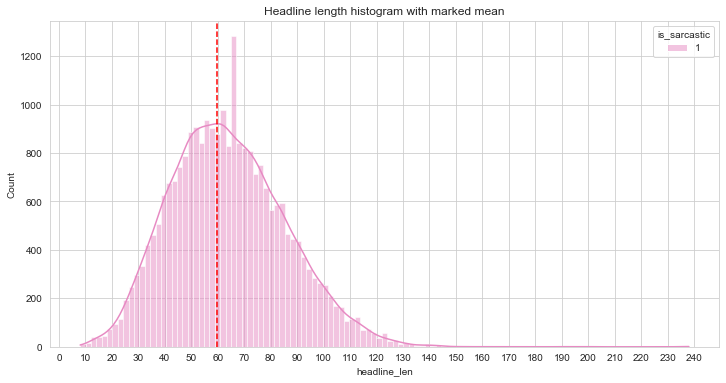

In [10]:
# Histogram of headline length for "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 1)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2_r').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 1
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

In [11]:
# List of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [12]:
sentences = []
labels = []

# append all headlines text and label (is_sarcastic) to list
for ind, row in df.iterrows():
  labels.append(row['is_sarcastic'])

  sentence = row['headline']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  sentences.append(sentence)

In [13]:
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      cln_sentences.append(text)
    return cln_sentences

sentences = clean_sentences(sentences)

In [14]:
# Set parameters
vocab_size = 10000    # Max len of unique words
embedding_dim = 200   # Embedding dimension value
max_length = 60       # Max length of sentence
padding_type = 'post' # pad_sequences arg
oov_tok = '<OOV>'     # Unknow words = <OOV>
training_portion = .7 # train test split 70:30

In [15]:
# Set the train size using training_portion arg
train_size = int(len(sentences) * training_portion)

# Split
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

# Check
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

38729
38729
38729
16599
16599


In [16]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length)

In [17]:
# Prepare labels for model
training_labels_final = np.array(train_labels)
validation_labels_final = np.array(validation_labels)

# Check shapes
print(training_labels_final.shape)
print(validation_labels_final.shape)

(38729,)
(16599,)


In [18]:
# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 40)                8040      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                        

In [20]:
# Fit the model
num_epochs = 6
history = model.fit(train_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))

Epoch 1/6
1211/1211 [==============================] - 33s 27ms/step - loss: 0.5892 - accuracy: 0.6668 - val_loss: 0.3396 - val_accuracy: 0.8629
Epoch 2/6
1211/1211 [==============================] - 32s 26ms/step - loss: 0.3551 - accuracy: 0.8580 - val_loss: 0.2102 - val_accuracy: 0.9180
Epoch 3/6
1211/1211 [==============================] - 32s 27ms/step - loss: 0.2306 - accuracy: 0.9224 - val_loss: 0.1452 - val_accuracy: 0.9480
Epoch 4/6
1211/1211 [==============================] - 31s 26ms/step - loss: 0.1631 - accuracy: 0.9464 - val_loss: 0.1113 - val_accuracy: 0.9641
Epoch 5/6
1211/1211 [==============================] - 32s 26ms/step - loss: 0.1120 - accuracy: 0.9665 - val_loss: 0.0946 - val_accuracy: 0.9759
Epoch 6/6
1211/1211 [==============================] - 31s 26ms/step - loss: 0.0777 - accuracy: 0.9762 - val_loss: 0.1089 - val_accuracy: 0.9781


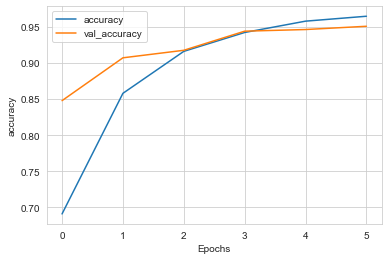

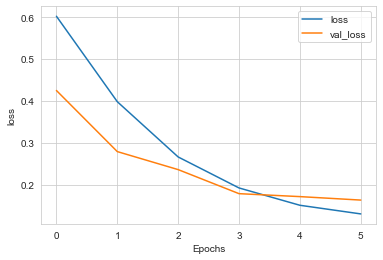

In [27]:
# Plot train and validation Accuracy and Loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
print("")
plot_graphs(history, "loss")

In [29]:
# Make prediction
pred = model.predict_classes(validation_padded)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [30]:
# Print Confusion matrix
print(classification_report(validation_labels, pred, target_names = ['Not Sarcastic','Sarcastic']))

NameError: name 'pred' is not defined